### Import

In [64]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

### Load

In [65]:

audioPath = "gym.mp3"
y, sr = librosa.load(audioPath, sr=None)

duration: 10.61 seconds
Sample rate: 44100 samples/second


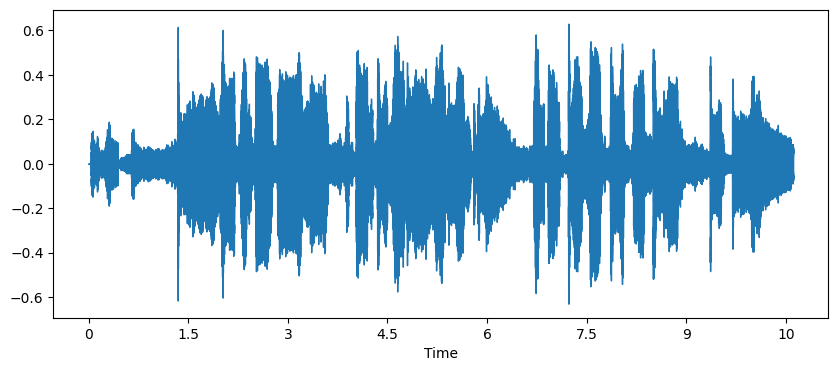

In [66]:
# plt.plot(y)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
duration = y.size / sr
print(f"duration: {duration} seconds")
print(f"Sample rate: {sr} samples/second")

### Low pass filter attenuates high frequencies above the cut off frequency.
### It uses the transfer function H(s) = 1 / (1 + sRC), where RC is the time constant.

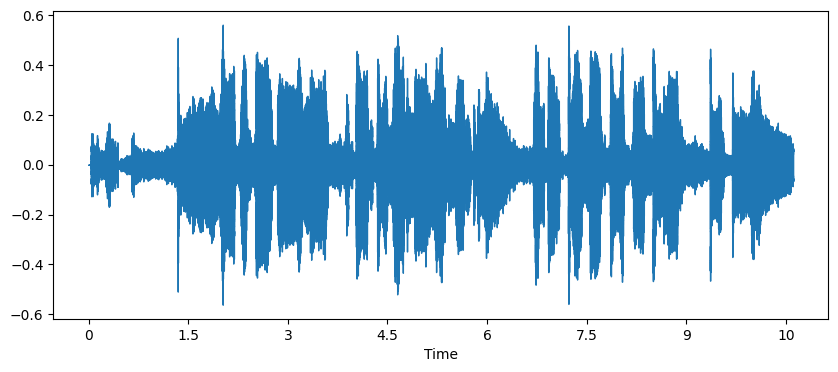

In [67]:
import math

cutoff_freq = 5000
rc = 1.0 / (2 * math.pi * cutoff_freq)
dt = 1.0 / sr
alpha = dt / (rc + dt)

fy = np.zeros_like(y)
prev_output = 0.0

for i, x in enumerate(y):
    prev_output = alpha * x + (1 - alpha) * prev_output
    fy[i] = prev_output

plt.figure(figsize=(10, 4))
librosa.display.waveshow(fy, sr=sr)
# plt.plot(fy)

### Downsample to target sample rate

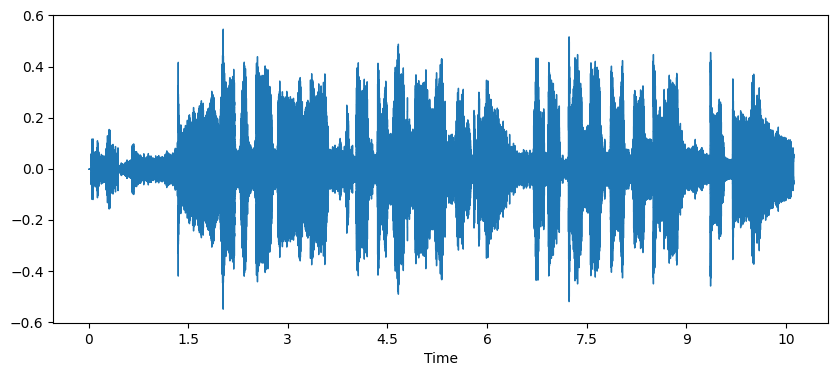

In [68]:
dsp_ratio = 4
target_sr = sr // dsp_ratio
ratio = sr // target_sr
if ratio <= 0:
    raise ValueError("Invalid ratio calculated from sample rates")

resampled = []
for i in range(0, len(fy), ratio):
    end = min(i + ratio, len(fy))
    segment = fy[i:end]
    avg = sum(segment) / len(segment)
    resampled.append(avg)

resampled = np.array(resampled)
sr = target_sr
plt.figure(figsize=(10, 4))
librosa.display.waveshow(resampled, sr=sr)
# plt.plot(resampled)

### Computes just one FFT of that first chunk of audio.

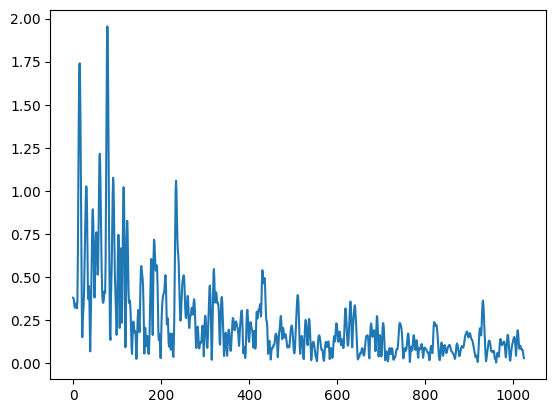

In [69]:
n_fft = 2048
ft = np.abs(librosa.stft(resampled[:n_fft], hop_length = n_fft+1)) # whole audio frame
plt.plot(ft)

### Fourier transform converts amplitude vs. time  to  amplitude vs. frequency

### Spectogram (linear)

STFT shape: 1025 x 115


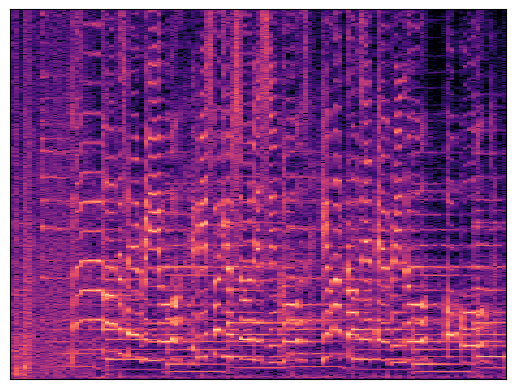

In [70]:
hop_length = 1024
ft = librosa.stft(resampled, hop_length=hop_length)
D = np.abs(ft)**2
spgm = librosa.power_to_db(D, ref=np.max)
# spgm = librosa.amplitude_to_db(D, ref=np.max)
fc, sc = ft.shape
print(f"STFT shape: {fc} x {sc}")
librosa.display.specshow(spgm, sr=sr)


### Mel spectogram : sensitive to difference in lower frequency (human friendly)

mel shape: 128 x 115


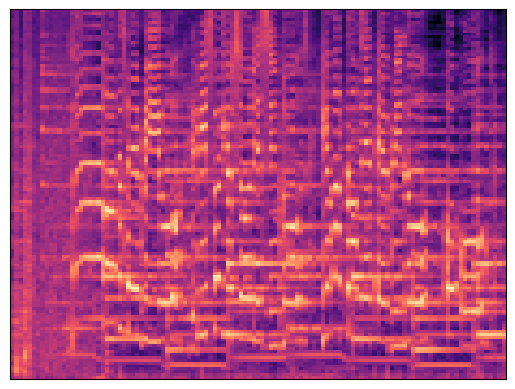

In [71]:
mel_spgm = librosa.feature.melspectrogram(y=resampled, sr=sr, n_fft=n_fft, hop_length=hop_length)
mel_spgm = librosa.power_to_db(mel_spgm, ref=np.max)
n_mels, sc = mel_spgm.shape
print(f"mel shape: {n_mels} x {sc}")
librosa.display.specshow(mel_spgm, fmax=8000)

### Extract significant peaks in the frequency domain over time

In [72]:
mel_freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr//2)
bin_duration = len(resampled)/sr / mel_spgm.shape[1]

peaks = []
for bin_idx, bin_data in enumerate(mel_spgm.T):  
    max_mag = np.max(bin_data)
    freq_idx = np.argmax(bin_data)
    if max_mag > np.mean(bin_data):  
        peak_time = bin_idx * bin_duration
        peak_freq = mel_freqs[freq_idx]
        peaks.append((peak_time, peak_freq))

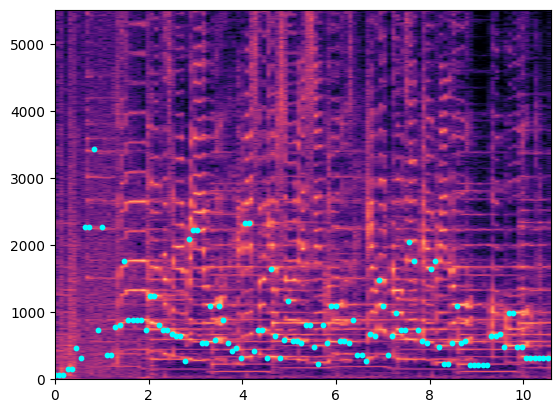

In [ ]:


time_axis = np.arange(ft.shape[1]) * hop_length / sr
freq_axis = np.linspace(0, sr/2, ft.shape[0])

extent = [0, time_axis[-1], freq_axis[0], freq_axis[-1]]
plt.imshow(spgm, origin="lower", aspect="auto", extent=extent, cmap="magma")

peak_times = [t for t, f in peaks]
peak_freqs = [np.abs(f) for t, f in peaks]  #
plt.scatter(peak_times, peak_freqs, color="cyan", marker="o", s=10)


### Form landmark pairs & Hash landmark
##### For each peak at (f1, t1) look ahead a short time window and pair it with another peak (f2, t2)
##### This creates a landmark pair (f1, f2, Δt) 
##### Combine (f1, f2, Δt) into a hash key.

In [ ]:
fan_value = 5   # number of peaks to consider after each anchor
target_zone = 200  

fingerprints = []

for i, anchor in enumerate(peaks):
    anchor_time, anchor_freq = anchor
    for j in range(1, fan_value+1):
        if i + j < len(peaks):
            target_time, target_freq = peaks[i + j]

            delta_time = target_time - anchor_time
            if 0 < delta_time <= target_zone / 1000:
                # Create a hashable tuple
                fp = (int(anchor_freq.real), int(target_freq.real), round(delta_time, 3))
                fingerprints.append((hash(fp), anchor_time))
len(fingerprints)

227